## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("../../../../h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OGradientBoostingEstimator
from h2o.estimators import H2OUpliftRandomForestEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.33.1',projectVersion='3.33.1.99999',branch='maurever_PUBDEV-4940_uplift_trees_poc',lastCommitHash='bdf64471f7777c8f2ff50b7806ab9bce6aeeba91',gitDescribe='jenkins-master-5554-71-gbdf64471f7-dirty',compiledOn='2021-09-07 23:48:30',compiledBy='potte'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 6 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024


In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OUpliftRandomForestEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                treatment_column=treatment_column,
                                                uplift_metric="KL",
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                auuc_type="gain"
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    start = time.time()
    gbm = H2OGradientBoostingEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99
                                                )
    gbm.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    gbm_time = end - start
    print(f"gbm Time: {gbm_time}s")    
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time, gbm_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    all_times_num_gbm = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        times_gbm = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time, gbm_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
            times_gbm.append(gbm_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        print(f"gbm {np.mean(times_gbm)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times_num_gbm.append(times_gbm)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s and gbm {np.mean(times_gbm)}s")

    uplift_means = dict()
    rf_means = dict()
    gbm_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}, gbm = {np.mean(all_times_num_gbm[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
        gbm_means[nthreads] = np.mean(all_times_num_gbm[i])
    
    return uplift_means, rf_means, gbm_means
        
    
def plot_result(eif_means, if_means, gbm_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    
        
    data_gbm = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_means.items():
        data_gbm["x"].append(label)
        data_gbm["y"].append(coord)         

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="UpliftRF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3)
    plt.plot(data_gbm['x'], data_gbm['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}; nbins = {nbins}")
    plt.savefig(f"h2o-scale-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [5]:
max_depths = []

In [6]:
N = 100000
P = 20
max_depth = 8
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
uplift_time7, rf_time7, gbm_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp08qxr296
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp08qxr296\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp08qxr296\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 minutes
H2O_cluster_name:,H2O_from_python_potte_gkzvdj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.12853455543518s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.811904430389404s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.08204984664917s
H2O session _sid_86ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqu6l0zav
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqu6l0zav\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqu6l0zav\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 minutes
H2O_cluster_name:,H2O_from_python_potte_t072yq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.41891598701477s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.998642921447754s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.806145906448364s
H2O session _sid_9ad4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf4lyc9hd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf4lyc9hd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf4lyc9hd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 minutes
H2O_cluster_name:,H2O_from_python_potte_sygp1m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.443283557891846s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.934181451797485s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.95849299430847s
H2O session _sid_9655 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2it2afc_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2it2afc_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2it2afc_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_potte_x9umm1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.779956340789795s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.735064268112183s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.64658212661743s
H2O session _sid_9857 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgpkq5bbz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgpkq5bbz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgpkq5bbz\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 minutes
H2O_cluster_name:,H2O_from_python_potte_7ay3n3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.836201667785645s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.538686275482178s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.97986626625061s
H2O session _sid_aaf7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq3cndlr_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq3cndlr_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq3cndlr_\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_potte_1decnu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.4264030456543s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.691739320755005s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.610628604888916s
H2O session _sid_b520 closed.
Uplift 48.338882525761925s
RF 13.785036444664001s
gbm 23.68062762419383s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4940i898
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4940i898\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 minutes
H2O_cluster_name:,H2O_from_python_potte_wdghe5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.502480030059814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.724313974380493s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.473169803619385s
H2O session _sid_9115 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm95vc48q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm95vc48q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm95vc48q\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 minutes
H2O_cluster_name:,H2O_from_python_potte_0g6bm1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |█████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.089869022369385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.54693865776062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.276787519454956s
H2O session _sid_82df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ijvlp_s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ijvlp_s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ijvlp_s\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 minutes
H2O_cluster_name:,H2O_from_python_potte_xrtuea
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.346888065338135s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 14.206587076187134s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.76347064971924s
H2O session _sid_94a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdfglpz_w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdfglpz_w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdfglpz_w\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,24 minutes
H2O_cluster_name:,H2O_from_python_potte_eximws
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.577237129211426s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.52837061882019s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.33246374130249s
H2O session _sid_b15a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxinbkzjd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxinbkzjd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxinbkzjd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,26 minutes
H2O_cluster_name:,H2O_from_python_potte_4ach71
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.15380668640137s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.859363079071045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.79322075843811s
H2O session _sid_90b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0vwpe_d9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0vwpe_d9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0vwpe_d9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,27 minutes
H2O_cluster_name:,H2O_from_python_potte_13ibsg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.06226563453674s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.293465614318848s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.41646695137024s
H2O session _sid_81ae closed.
Uplift 46.12209109465281s
RF 13.693173170089722s
gbm 21.842596570650738s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6xyc0k7w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6xyc0k7w\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,29 minutes
H2O_cluster_name:,H2O_from_python_potte_gk7ker
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.86160683631897s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.54368257522583s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.178683042526245s
H2O session _sid_9045 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnfvu97sk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnfvu97sk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnfvu97sk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,31 minutes
H2O_cluster_name:,H2O_from_python_potte_4j4hjc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.05391812324524s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.64189863204956s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.673451900482178s
H2O session _sid_aad2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpztvldxk2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpztvldxk2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpztvldxk2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,32 minutes
H2O_cluster_name:,H2O_from_python_potte_24l5xj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.09502172470093s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.999354839324951s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.979993104934692s
H2O session _sid_b5c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwdh3lit9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwdh3lit9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwdh3lit9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,34 minutes
H2O_cluster_name:,H2O_from_python_potte_fy7dj0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.89251732826233s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.493672370910645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.427157163619995s
H2O session _sid_9635 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeysw_73k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeysw_73k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeysw_73k\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,36 minutes
H2O_cluster_name:,H2O_from_python_potte_7g9f57
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.08606719970703s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.141191244125366s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.08917737007141s
H2O session _sid_b393 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv02jdjt9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv02jdjt9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv02jdjt9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,37 minutes
H2O_cluster_name:,H2O_from_python_potte_yqphph
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.08857464790344s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.156009197235107s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.245635509490967s
H2O session _sid_9ca9 closed.
Uplift 44.51295097668966s
RF 12.829301476478577s
gbm 19.599016348520916s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxpeibkjy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxpeibkjy\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,39 minutes
H2O_cluster_name:,H2O_from_python_potte_yyca3e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.454432249069214s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.962482929229736s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.152268886566162s
H2O session _sid_b9d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpofskph_h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpofskph_h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpofskph_h\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,41 minutes
H2O_cluster_name:,H2O_from_python_potte_kb96pr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.410396099090576s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.343719482421875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.290220260620117s
H2O session _sid_b816 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp079ddmh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp079ddmh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp079ddmh\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_ey7k5m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.30542254447937s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.020706176757812s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.915755033493042s
H2O session _sid_b3b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwque8_f3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwque8_f3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwque8_f3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_1t7w2l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.531861782073975s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.034600257873535s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.052727937698364s
H2O session _sid_9cd4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnxb6zcfs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnxb6zcfs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnxb6zcfs\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,46 minutes
H2O_cluster_name:,H2O_from_python_potte_ydxmdu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.47653841972351s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.282260417938232s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.90112018585205s
H2O session _sid_9f8f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjo9009cw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjo9009cw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjo9009cw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,48 minutes
H2O_cluster_name:,H2O_from_python_potte_yrurev
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.51270341873169s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.9655020236969s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.838064193725586s
H2O session _sid_91bc closed.
Uplift 44.44855908552805s
RF 12.934878547986349s
gbm 18.358359416325886s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpij00ou58
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpij00ou58\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_potte_37o7to
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.695608615875244s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.086360931396484s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.755495071411133s
H2O session _sid_be02 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2l0ncpgt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2l0ncpgt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2l0ncpgt\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_10h4wy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.669880628585815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.957650184631348s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.78248929977417s
H2O session _sid_b5f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe8gqfebm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe8gqfebm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe8gqfebm\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_f11w4a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.946152210235596s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.078836441040039s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.68966007232666s
H2O session _sid_acce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmnp8u_79
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmnp8u_79\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmnp8u_79\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_potte_kd5h6z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.88963198661804s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.098479986190796s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.721182346343994s
H2O session _sid_abe8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp532p7_10
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp532p7_10\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp532p7_10\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_mc3un1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.599661350250244s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.17782711982727s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.818556785583496s
H2O session _sid_8ee6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphv1dxd3_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphv1dxd3_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphv1dxd3_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_potte_gpjjbg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.62523126602173s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.014767408370972s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.80773949623108s
H2O session _sid_8a7a closed.
Uplift 46.90436100959778s
RF 13.068987011909485s
gbm 17.762520511945088s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyybnj1i7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyybnj1i7\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,59 minutes
H2O_cluster_name:,H2O_from_python_potte_9xausp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.32321786880493s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.577210187911987s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.351311206817627s
H2O session _sid_bc0a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm0wxohtk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm0wxohtk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm0wxohtk\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_hl01mj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.67135643959045s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.694177865982056s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.488072633743286s
H2O session _sid_b811 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb7k02x0_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb7k02x0_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb7k02x0_\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_m2e889
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 69.05712819099426s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.565486192703247s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 24.66992473602295s
H2O session _sid_a320 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps_imxg1e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps_imxg1e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps_imxg1e\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_gb2r3e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 67.30244636535645s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.40341877937317s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.398394346237183s
H2O session _sid_8d4a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwch1u3g_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwch1u3g_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwch1u3g_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_8r9jro
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.93667221069336s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.713348388671875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.469839334487915s
H2O session _sid_a5df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp76_q9cm9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp76_q9cm9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp76_q9cm9\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_vuqf20
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 67.74143075942993s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.744430541992188s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.28085970878601s
H2O session _sid_89c6 closed.
Uplift 68.8387086391449s
RF 17.949678659439087s
gbm 25.276400327682495s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpukwmhkru
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpukwmhkru\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_3d6jnp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.90150094032288s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.926521062850952s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 43.34039258956909s
H2O session _sid_85c1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwiopb1vc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwiopb1vc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwiopb1vc\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_91th1k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.97981333732605s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.8966646194458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 43.29376244544983s
H2O session _sid_9a82 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5c4hhlkx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5c4hhlkx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5c4hhlkx\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_8an7hp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.86990737915039s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.28121328353882s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 42.12767314910889s
H2O session _sid_8dfa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp82uuwojw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp82uuwojw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp82uuwojw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_vzwlgn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.55791878700256s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.38231348991394s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 42.063045263290405s
H2O session _sid_a599 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8tzzc9q9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8tzzc9q9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8tzzc9q9\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_7pe0xh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.91111016273499s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.57054853439331s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 43.38328528404236s
H2O session _sid_9526 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgoayd1j0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgoayd1j0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgoayd1j0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_nzmwug
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 114.31849193572998s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.054779529571533s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 42.73825526237488s
H2O session _sid_8ad5 closed.
Uplift 114.58979042371114s
RF 30.852006753285725s
gbm 42.82440233230591s
12 - Uplift = 48.338882525761925, RF = 13.785036444664001, gbm = 23.68062762419383
10 - Uplift = 46.12209109465281, RF = 13.693173170089722, gbm = 21.842596570650738
8 - Uplift = 44.51295097668966, RF = 12.829301476478577, gbm = 19.599016348520916
6 - Uplift = 44.44855908552805, RF = 12.934878547986349, gbm = 18.358359416325886
4 - Uplift = 46.90436100959778, RF = 13.068987011909485, gbm = 17.762520511945088
2 - Uplift = 6

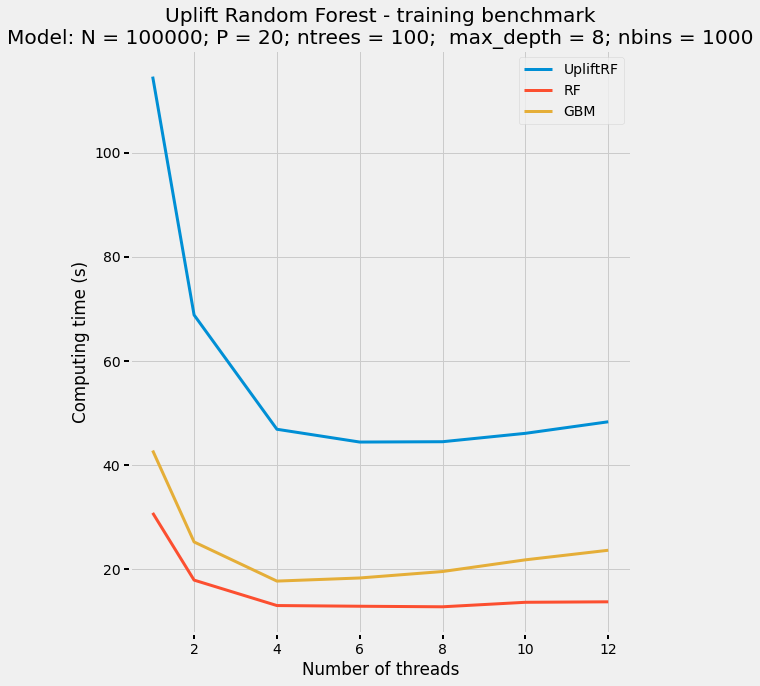

In [8]:
plot_result(uplift_time7, rf_time7, gbm_time7)

In [9]:
N = 100000
P = 20
max_depth = 16
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
uplift_time8, rf_time8, gbm_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6zu6ndja
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6zu6ndja\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6zu6ndja\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_0wjf99
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.94219303131104s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.8114631175995s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 368.0512897968292s
H2O session _sid_b745 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbmkr0349
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbmkr0349\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbmkr0349\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_2kq5he
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 289.6522741317749s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.61292791366577s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 364.60517382621765s
H2O session _sid_a119 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkwgg1j_8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkwgg1j_8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkwgg1j_8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_qa4d9d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 289.9565074443817s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.58241248130798s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 369.8675699234009s
H2O session _sid_bf78 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaj5tbtqd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaj5tbtqd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaj5tbtqd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_h59u23
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 290.8982539176941s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.5894467830658s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 373.899475812912s
H2O session _sid_b4f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4n62rlnv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4n62rlnv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4n62rlnv\h2o_potte_started_from_python.err

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_lhfqzu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 300.1515381336212s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 135.9410433769226s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 391.52886843681335s
H2O session _sid_83bf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp96bg0cl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp96bg0cl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp96bg0cl\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_gjwjw6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 303.2222170829773s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.3559319972992s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 403.72310090065s
H2O session _sid_bbf5 closed.
Uplift 295.63716395696s
RF 134.1488709449768s
gbm 378.61257978280383s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkj32gl7f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkj32gl7f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\p

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_q42znc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 287.11588621139526s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 126.21191477775574s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 348.35465240478516s
H2O session _sid_a667 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkwcs15ff
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkwcs15ff\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkwcs15ff\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_ej7s1v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 277.16392159461975s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 121.35372543334961s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 326.8397104740143s
H2O session _sid_851c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl81wh09n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl81wh09n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl81wh09n\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_eynbyg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 277.8824636936188s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 123.44386529922485s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 316.17992186546326s
H2O session _sid_9a40 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp65w90buw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp65w90buw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp65w90buw\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_zlvzdz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 264.37830424308777s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 115.27932262420654s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 316.75589299201965s
H2O session _sid_8f85 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0q1syqab
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0q1syqab\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0q1syqab\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_w67v5k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 266.41510248184204s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 113.99480938911438s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 321.888968706131s
H2O session _sid_83e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpshltgr7w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpshltgr7w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpshltgr7w\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours
H2O_cluster_name:,H2O_from_python_potte_7uu05d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 260.6840703487396s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 116.54061532020569s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 318.96818447113037s
H2O session _sid_b9a2 closed.
Uplift 272.27329142888385s
RF 119.47070880730946s
gbm 324.83122181892395s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa6szhkmz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa6szhkmz\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_ssobrt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 246.97173643112183s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.65561652183533s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 277.7749135494232s
H2O session _sid_8b21 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9us_7d11
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9us_7d11\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9us_7d11\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_aormzw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 245.7290678024292s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.62345767021179s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 275.41781783103943s
H2O session _sid_bdbe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv87et36j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv87et36j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv87et36j\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_4jxhdm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 244.69008350372314s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 103.61692571640015s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.8315210342407s
H2O session _sid_9cd4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmped64bfm3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmped64bfm3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmped64bfm3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_tdpcds
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 243.70758247375488s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.761883020401s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.4341170787811s
H2O session _sid_b811 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe5obvh_e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe5obvh_e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe5obvh_e\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_pgwxsr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 243.22687673568726s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.00620651245117s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 278.79210090637207s
H2O session _sid_8d10 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi79vi88q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi79vi88q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi79vi88q\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_dmf5u5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 243.70605945587158s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.54460334777832s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.72298073768616s
H2O session _sid_ad15 closed.
Uplift 244.671901067098s
RF 103.3681154648463s
gbm 276.99557518959045s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3vcgvotr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3vcgvotr\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_p8ysei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 225.89787888526917s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.85833859443665s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 226.02077770233154s
H2O session _sid_8d82 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcjdb7o6d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcjdb7o6d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcjdb7o6d\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_41m4ri
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 233.74283742904663s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.62781834602356s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.86036276817322s
H2O session _sid_9ff2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr1_kyo9a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr1_kyo9a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr1_kyo9a\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_tyrq2q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 241.81162571907043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.60045385360718s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 250.70810770988464s
H2O session _sid_b378 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuftu39rd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuftu39rd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuftu39rd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_yiozoc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 241.64882922172546s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.51549339294434s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 248.16031169891357s
H2O session _sid_88f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8s8l5yl6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8s8l5yl6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8s8l5yl6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_562ffu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 244.23285841941833s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.13747978210449s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 251.57157802581787s
H2O session _sid_a1c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp41ij1fzf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp41ij1fzf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp41ij1fzf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_gzodf5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 237.5953345298767s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.96752452850342s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 241.29382872581482s
H2O session _sid_ae91 closed.
Uplift 237.48822736740112s
RF 96.95118474960327s
gbm 243.76916110515594s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4gts0qof
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4gts0qof\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_ijphdp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 223.8897533416748s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.62921380996704s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 195.0309329032898s
H2O session _sid_9471 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphlcd6che
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphlcd6che\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphlcd6che\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_ay3eqb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 221.1170153617859s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.02749919891357s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 186.8818175792694s
H2O session _sid_8a92 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5zcydh74
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5zcydh74\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5zcydh74\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_yuwl0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 214.0244288444519s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.90329813957214s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 181.0656383037567s
H2O session _sid_9eab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp61v66_dt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp61v66_dt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp61v66_dt\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_1nc3l1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 216.65971755981445s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.88998413085938s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 185.88924360275269s
H2O session _sid_a3db closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw8ydikti
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw8ydikti\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw8ydikti\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_3o4y33
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 215.5416111946106s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.79302644729614s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 185.47278332710266s
H2O session _sid_a9ad closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvsqehr1s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvsqehr1s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvsqehr1s\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_e7h8xm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 215.16975259780884s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.87422585487366s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 185.79527950286865s
H2O session _sid_bf5d closed.
Uplift 217.7337131500244s
RF 83.686207930247s
gbm 186.68928253650665s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfh6zcmfu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfh6zcmfu\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_dtihvg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.6416416168213s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.61590576171875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 191.99578714370728s
H2O session _sid_ae4f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm4sz9m5e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm4sz9m5e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm4sz9m5e\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_9airbf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.0266797542572s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.02540135383606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 192.3233060836792s
H2O session _sid_826d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3pxtfcr_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3pxtfcr_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3pxtfcr_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_pyrzxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 290.7381548881531s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.79938983917236s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 194.5819787979126s
H2O session _sid_8725 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpttv8g64b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpttv8g64b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpttv8g64b\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_1m7qhz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 287.78876399993896s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.56158375740051s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 195.91562700271606s
H2O session _sid_9758 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcr1qwg39
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcr1qwg39\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcr1qwg39\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_fl5v35
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.84530091285706s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.06884837150574s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 190.547954082489s
H2O session _sid_8729 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphcfa4c7f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphcfa4c7f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphcfa4c7f\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_fwaujk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.69488191604614s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 101.58494687080383s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 193.74423217773438s
H2O session _sid_8977 closed.
Uplift 290.78923718134564s
RF 100.94267932573955s
gbm 193.18481421470642s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9_ne3g1l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9_ne3g1l\h2o_potte_started_from_python.out
  JVM stderr: C

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_o2hw2z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 475.65436244010925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 166.74185943603516s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 273.1595616340637s
H2O session _sid_a41b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3qsj3t_h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3qsj3t_h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3qsj3t_h\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_40lxh0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 473.56723642349243s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 164.70635676383972s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 272.5567054748535s
H2O session _sid_b1d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl5zgpzf2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl5zgpzf2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl5zgpzf2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_8eziee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 475.7476317882538s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 168.1177577972412s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 277.1382236480713s
H2O session _sid_a306 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_nn7hseb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_nn7hseb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_nn7hseb\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_7w489e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 473.41349601745605s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 167.18937587738037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 272.08316349983215s
H2O session _sid_a58b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt3rsocop
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt3rsocop\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt3rsocop\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_n4qml6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 475.1135275363922s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 164.92983222007751s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 274.6531710624695s
H2O session _sid_9661 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp91018mxz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp91018mxz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp91018mxz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_r4xqa5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 469.3507390022278s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 165.8490686416626s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 271.7991421222687s
H2O session _sid_acc1 closed.
Uplift 473.8078322013219s
RF 166.25570845603943s
gbm 273.56499457359314s
12 - Uplift = 295.63716395696, RF = 134.1488709449768, gbm = 378.61257978280383
10 - Uplift = 272.27329142888385, RF = 119.47070880730946, gbm = 324.83122181892395
8 - Uplift = 244.671901067098, RF = 103.3681154648463, gbm = 276.99557518959045
6 - Uplift = 237.48822736740112, RF = 96.95118474960327, gbm = 243.76916110515594
4 - Uplift = 217.7337131500244, RF = 83.686207930247, gbm = 186.68928253650665
2 - Uplift = 290.789237

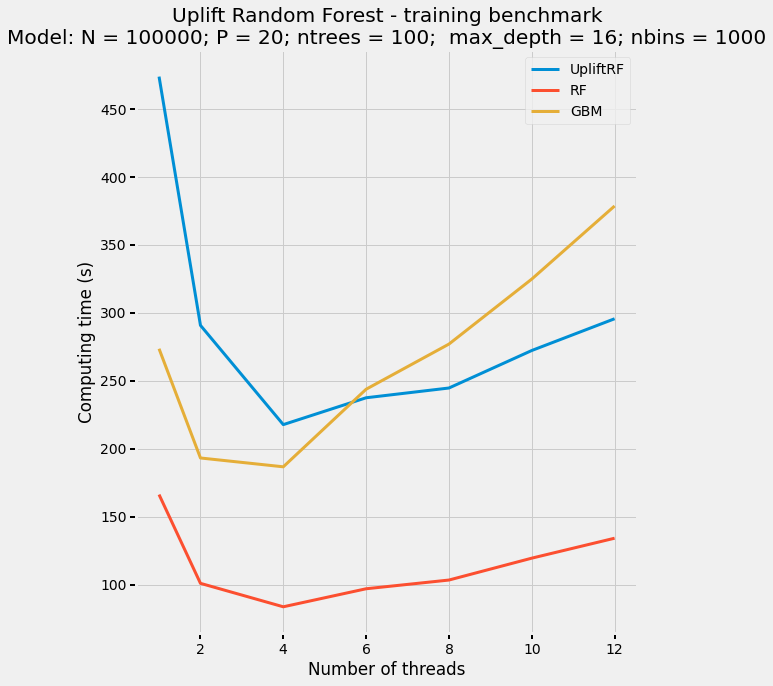

In [11]:
plot_result(uplift_time8, rf_time8, gbm_time8)

### Bigger sample_size

In [12]:
N = 100000
P = 20
max_depth = 20
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
uplift_time9, rf_time9, gbm_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvdvm6c4x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvdvm6c4x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvdvm6c4x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_yrsf0e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 437.3493149280548s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 156.28835272789001s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 740.4047486782074s
H2O session _sid_8b5b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy6s3ydpc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy6s3ydpc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy6s3ydpc\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_xntqta
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 434.5066092014313s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 158.69296264648438s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 742.6164705753326s
H2O session _sid_9451 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplrwkzoof
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplrwkzoof\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplrwkzoof\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_i8ktg8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 436.1163251399994s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 155.51087641716003s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 746.1103820800781s
H2O session _sid_af1e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi92fcwnh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi92fcwnh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi92fcwnh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_i2pwmb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 438.92684173583984s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 156.45304536819458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 747.5436990261078s
H2O session _sid_8d4c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv_4d9x8a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv_4d9x8a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv_4d9x8a\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_xfd9ws
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 438.08816170692444s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 157.27150535583496s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 741.7154324054718s
H2O session _sid_8b9a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp7hta2k7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp7hta2k7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp7hta2k7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_wfsg6l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 436.91093707084656s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 159.3586528301239s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 749.867157459259s
H2O session _sid_8902 closed.
Uplift 436.98303163051605s
RF 157.26256589094797s
gbm 744.7096483707428s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp99dll9an
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp99dll9an\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_az82pj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.3351294994354s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.63877701759338s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 674.0788702964783s
H2O session _sid_a433 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp467o_up1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp467o_up1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp467o_up1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_c8g53m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.38349986076355s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.2767140865326s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 671.627848148346s
H2O session _sid_94f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp625kjfyl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp625kjfyl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp625kjfyl\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_zemrc1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 402.2211878299713s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.3631627559662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 670.3195531368256s
H2O session _sid_9b28 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp90ie755z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp90ie755z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp90ie755z\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_e634ei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 401.5142023563385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 139.22101759910583s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 666.2893118858337s
H2O session _sid_8c59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdyr5ipg3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdyr5ipg3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdyr5ipg3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_s97q9t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 404.4222905635834s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.48506927490234s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 670.7119016647339s
H2O session _sid_b682 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps50w42pz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps50w42pz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps50w42pz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_n8p584
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 405.43726873397827s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 139.2346396446228s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 668.3570754528046s
H2O session _sid_94f0 closed.
Uplift 402.8855964740117s
RF 140.03656339645386s
gbm 670.2307600975037s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfk0wca89
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfk0wca89\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_uw91gy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 373.12384057044983s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 120.70124816894531s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 585.552757024765s
H2O session _sid_a82a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxjmutnni
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxjmutnni\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxjmutnni\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_65vwhr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 371.69378304481506s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 123.44400215148926s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 586.6540567874908s
H2O session _sid_aaeb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxx77ysa2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxx77ysa2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxx77ysa2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_5vyaaj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.57816767692566s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.40867280960083s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 580.7159795761108s
H2O session _sid_8b0c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm4usdz89
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm4usdz89\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm4usdz89\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_h2whsj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.3605840206146s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.9710783958435s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 589.732138633728s
H2O session _sid_8299 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmejsbfb_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmejsbfb_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmejsbfb_\h2o_potte_started_from_python.err

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_ec4fk9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 373.3925290107727s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.50533366203308s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 587.4633386135101s
H2O session _sid_aecf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzwyb620o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzwyb620o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzwyb620o\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_gcwfqq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 372.8378984928131s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 121.71668887138367s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 589.7931797504425s
H2O session _sid_8744 closed.
Uplift 373.6644671360652s
RF 122.29117067654927s
gbm 586.6519083976746s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv4bwq0hi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv4bwq0hi\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_dqr26h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 341.14540791511536s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 111.35206151008606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 489.90543723106384s
H2O session _sid_99c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1n4mvln4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1n4mvln4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1n4mvln4\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_ofmbly
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 344.14716053009033s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.78569054603577s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 500.3981375694275s
H2O session _sid_91f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdku4f759
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdku4f759\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdku4f759\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_l6x90l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 344.49629044532776s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.70241737365723s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 494.9684188365936s
H2O session _sid_9f29 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpda6jo_tf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpda6jo_tf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpda6jo_tf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_m78qsg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 342.85467171669006s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.82340717315674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 499.5890967845917s
H2O session _sid_893d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8p6vuyea
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8p6vuyea\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8p6vuyea\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_90xiiy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 345.4754786491394s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.76509666442871s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 492.1310851573944s
H2O session _sid_b7ff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7obramy9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7obramy9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7obramy9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_du5pcm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 343.63803267478943s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.56763195991516s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 499.7070698738098s
H2O session _sid_acb3 closed.
Uplift 343.6261736551921s
RF 108.33271753787994s
gbm 496.1165409088135s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvmw_3lcq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvmw_3lcq\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_th1wfh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.90843868255615s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.54926896095276s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 399.77268958091736s
H2O session _sid_9986 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0579zkxe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0579zkxe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0579zkxe\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_mytaen
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.96088457107544s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.96104717254639s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 410.12429451942444s
H2O session _sid_a215 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm9ifb6u9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm9ifb6u9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm9ifb6u9\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_vh5ju2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 321.972589969635s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.63085794448853s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 408.1498613357544s
H2O session _sid_9e13 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf3bp3o4s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf3bp3o4s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf3bp3o4s\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_i8j48s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.9899740219116s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.71118474006653s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 404.3940591812134s
H2O session _sid_9124 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp74a6463h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp74a6463h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp74a6463h\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_o2lqhk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 321.09159684181213s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.83110237121582s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 408.25338888168335s
H2O session _sid_848c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmz6ifx4t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmz6ifx4t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmz6ifx4t\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_ejchwi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 322.88467597961426s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.38727974891663s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 409.67531061172485s
H2O session _sid_a936 closed.
Uplift 320.80136001110077s
RF 99.17845682303111s
gbm 406.7282673517863s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp23qjq1tq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp23qjq1tq\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_11g6ow
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 414.26474261283875s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.20871067047119s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 406.4661474227905s
H2O session _sid_994c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptuiww7tc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptuiww7tc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptuiww7tc\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_l7yu7h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 415.1692509651184s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 120.1022481918335s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 402.2147798538208s
H2O session _sid_938d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprfa0m89l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprfa0m89l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprfa0m89l\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_qut3q7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 425.9383990764618s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 123.31572389602661s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 410.96102380752563s
H2O session _sid_ae1b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn28g_2l4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn28g_2l4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn28g_2l4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_ardaav
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 417.0606517791748s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.99370741844177s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 413.10789012908936s
H2O session _sid_a539 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6mtmt4mi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6mtmt4mi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6mtmt4mi\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours
H2O_cluster_name:,H2O_from_python_potte_hysq7i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 419.97403955459595s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.1488356590271s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 411.58153653144836s
H2O session _sid_8dff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnr07b6ba
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnr07b6ba\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnr07b6ba\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_w4x8k1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 414.2123885154724s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 120.71534633636475s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 397.54808044433594s
H2O session _sid_bfb0 closed.
Uplift 417.76991208394367s
RF 121.91409536202748s
gbm 406.97990969816846s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpny393hpq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpny393hpq\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_mzv8nw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 680.109635591507s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 203.7844376564026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 535.3213803768158s
H2O session _sid_be30 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpold8p576
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpold8p576\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpold8p576\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_9nvv5a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 668.1253755092621s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 200.89272904396057s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 522.2958171367645s
H2O session _sid_81e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvwdzyx06
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvwdzyx06\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvwdzyx06\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_ni8c4o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 683.0243690013885s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 199.088773727417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 540.5192718505859s
H2O session _sid_8c79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoj9tr4f0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoj9tr4f0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoj9tr4f0\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_28gb94
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 679.6706635951996s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 204.26956725120544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 536.6078824996948s
H2O session _sid_953f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjhonh5ei
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjhonh5ei\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjhonh5ei\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_bwo0hi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 682.056291103363s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 201.99234771728516s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 529.482225894928s
H2O session _sid_998c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy5o0l_ol
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy5o0l_ol\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy5o0l_ol\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_z4leia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 680.2596182823181s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 201.49760055541992s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 555.5014100074768s
H2O session _sid_b62a closed.
Uplift 678.8743255138397s
RF 201.92090932528177s
gbm 536.6213312943777s
12 - Uplift = 436.98303163051605, RF = 157.26256589094797, gbm = 744.7096483707428
10 - Uplift = 402.8855964740117, RF = 140.03656339645386, gbm = 670.2307600975037
8 - Uplift = 373.6644671360652, RF = 122.29117067654927, gbm = 586.6519083976746
6 - Uplift = 343.6261736551921, RF = 108.33271753787994, gbm = 496.1165409088135
4 - Uplift = 320.80136001110077, RF = 99.17845682303111, gbm = 406.7282673517863
2 - Uplift = 417.769

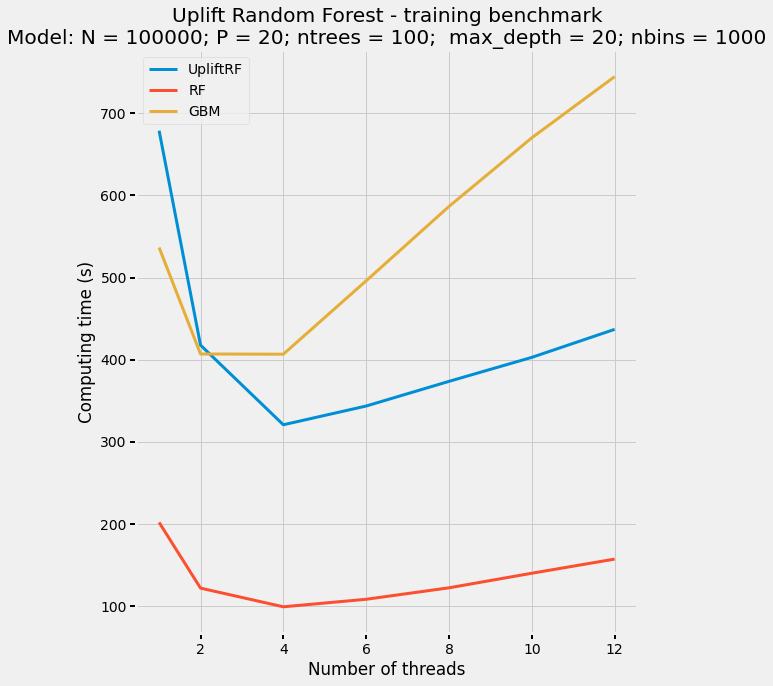

In [14]:
plot_result(uplift_time9, rf_time9, gbm_time9)

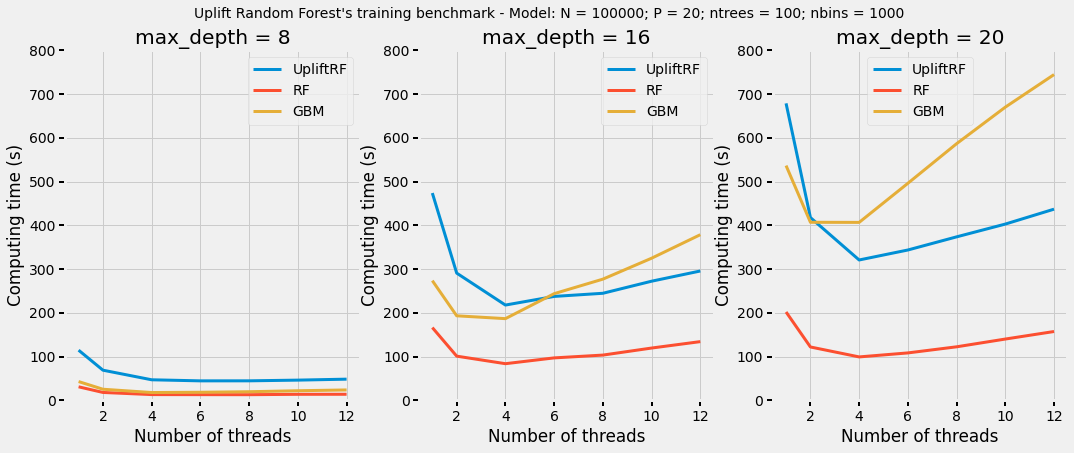

In [15]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 48.338882525761925, 10: 46.12209109465281, 8: 44.51295097668966, 6: 44.44855908552805, 4: 46.90436100959778, 2: 68.8387086391449, 1: 114.58979042371114}, {12: 295.63716395696, 10: 272.27329142888385, 8: 244.671901067098, 6: 237.48822736740112, 4: 217.7337131500244, 2: 290.78923718134564, 1: 473.8078322013219}, {12: 436.98303163051605, 10: 402.8855964740117, 8: 373.6644671360652, 6: 343.6261736551921, 4: 320.80136001110077, 2: 417.76991208394367, 1: 678.8743255138397}]


In [17]:
print(all_predict_rf)

[{12: 13.785036444664001, 10: 13.693173170089722, 8: 12.829301476478577, 6: 12.934878547986349, 4: 13.068987011909485, 2: 17.949678659439087, 1: 30.852006753285725}, {12: 134.1488709449768, 10: 119.47070880730946, 8: 103.3681154648463, 6: 96.95118474960327, 4: 83.686207930247, 2: 100.94267932573955, 1: 166.25570845603943}, {12: 157.26256589094797, 10: 140.03656339645386, 8: 122.29117067654927, 6: 108.33271753787994, 4: 99.17845682303111, 2: 121.91409536202748, 1: 201.92090932528177}]


In [18]:
print(all_predict_gbm)

[{12: 23.68062762419383, 10: 21.842596570650738, 8: 19.599016348520916, 6: 18.358359416325886, 4: 17.762520511945088, 2: 25.276400327682495, 1: 42.82440233230591}, {12: 378.61257978280383, 10: 324.83122181892395, 8: 276.99557518959045, 6: 243.76916110515594, 4: 186.68928253650665, 2: 193.18481421470642, 1: 273.56499457359314}, {12: 744.7096483707428, 10: 670.2307600975037, 8: 586.6519083976746, 6: 496.1165409088135, 4: 406.7282673517863, 2: 406.97990969816846, 1: 536.6213312943777}]


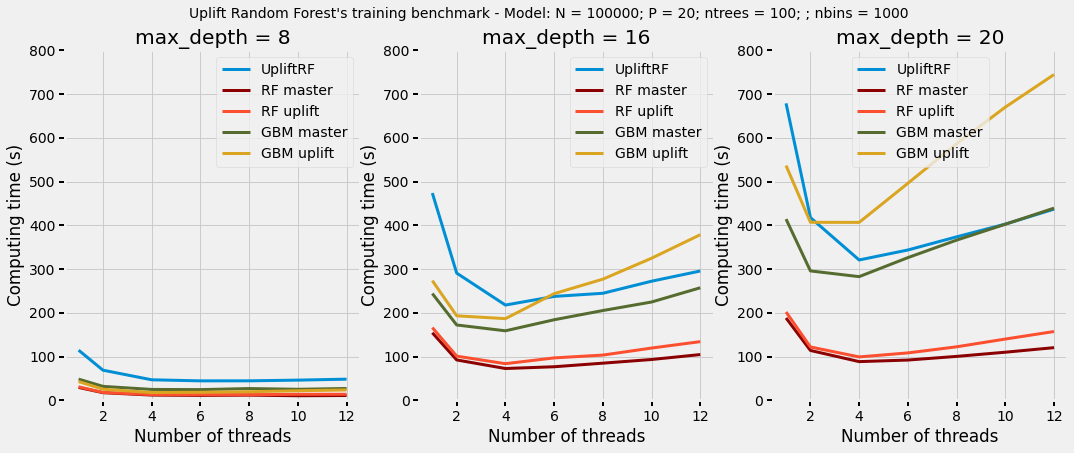

In [19]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf_uplift = [rf_time7, rf_time8, rf_time9]
all_predict_gbm_uplift = [gbm_time7, gbm_time8, gbm_time9]
all_predict_gbm_master = [{12: 26.986810167630512, 10: 25.17754093805949, 8: 26.859924117724102, 6: 24.445232311884563, 4: 24.84089493751526, 2: 31.85128080844879, 1: 48.42471953233083}, {12: 257.28191316127777, 10: 224.729074438413, 8: 205.23646970589957, 6: 184.1432944138845, 4: 158.8846471707026, 2: 172.22614924112955, 1: 244.03339886665344}, {12: 439.31534298261005, 10: 402.45600994427997, 8: 366.2033998966217, 6: 326.18388803799945, 4: 282.70726378758746, 2: 295.7804197072983, 1: 414.2765694061915}]
all_predict_rf_master = [{12: 10.9469602505366, 10: 10.434547702471415, 8: 11.785475413004557, 6: 11.237413684527079, 4: 11.944405476252237, 2: 17.41841967900594, 1: 29.419774015744526}, {12: 104.57699644565582, 10: 93.2722510099411, 8: 84.90028929710388, 6: 76.68593625227611, 4: 72.69012920061748, 2: 92.24727594852448, 1: 154.36357283592224}, {12: 120.36679824193318, 10: 109.93499068419139, 8: 100.37291808923085, 6: 92.02097642421722, 4: 88.43221167723338, 2: 113.96409718195598, 1: 188.21300756931305}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; ; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color="darkolivegreen")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [20]:
nbinss = []

In [21]:
N = 100000
P = 20
max_depth = 16
nbins=20
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [22]:
uplift_time0, rf_time0, gbm_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5huj_kf6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5huj_kf6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5huj_kf6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_3ro8jy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 53.78928828239441s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.045156240463257s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.172378063201904s
H2O session _sid_817e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfsria_lu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfsria_lu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfsria_lu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_g36ox8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 60.86493635177612s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.313615560531616s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.16506266593933s
H2O session _sid_8aed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyf9wwtcr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyf9wwtcr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyf9wwtcr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_e88zp9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.10150170326233s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 28.907217502593994s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 39.14360237121582s
H2O session _sid_aec2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq8s6wnjp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq8s6wnjp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq8s6wnjp\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_6rqrif
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 52.523404598236084s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.0695698261261s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.37971639633179s
H2O session _sid_a2e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2bsq5mer
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2bsq5mer\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2bsq5mer\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_btezee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 53.67709016799927s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 23.763156175613403s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.39199614524841s
H2O session _sid_a695 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe2m0e2cl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe2m0e2cl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe2m0e2cl\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_a1b8sz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 53.87429118156433s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 24.485164880752563s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 39.719372034072876s
H2O session _sid_bae2 closed.
Uplift 55.30508538087209s
RF 26.430646697680157s
gbm 38.66202127933502s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg6q2j1yv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg6q2j1yv\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_4if8ps
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.76368832588196s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 23.11944031715393s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 32.78454923629761s
H2O session _sid_a0a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp396jcm2a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp396jcm2a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp396jcm2a\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_uvvhl2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.021190881729126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.348620891571045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.010671138763428s
H2O session _sid_803c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk9as_u51
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk9as_u51\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk9as_u51\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_esp0q7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.09751915931702s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.760237216949463s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.3570716381073s
H2O session _sid_9b95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4ikxwnn0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4ikxwnn0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4ikxwnn0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_lljsim
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.89147067070007s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.563106060028076s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 32.96231007575989s
H2O session _sid_b983 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbba4xbxb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbba4xbxb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbba4xbxb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_gkk9mh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.44766020774841s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.58805561065674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.65505075454712s
H2O session _sid_8428 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprrdvmacr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprrdvmacr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprrdvmacr\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_stvque
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.718735694885254s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.99744725227356s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.763314485549927s
H2O session _sid_98fe closed.
Uplift 49.32337749004364s
RF 21.72948455810547s
gbm 31.08882788817088s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmper5k3wq3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmper5k3wq3\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_ns9bdh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.80652856826782s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 23.115309715270996s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.186381101608276s
H2O session _sid_b70f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp652f5als
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp652f5als\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp652f5als\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_2bowo8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.610880613327026s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.75113821029663s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 28.573208808898926s
H2O session _sid_90b7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzksfb_dj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzksfb_dj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzksfb_dj\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_l3e8xp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.31027674674988s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.48066234588623s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.85106372833252s
H2O session _sid_bbca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwkf_lxp9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwkf_lxp9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwkf_lxp9\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_vdacou
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.35235953330994s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.82653498649597s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.31497311592102s
H2O session _sid_b786 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw685dng7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw685dng7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw685dng7\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_0t4ibl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.226386070251465s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.682260751724243s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.106515884399414s
H2O session _sid_a98a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4b0_bybc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4b0_bybc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4b0_bybc\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_i93moe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.62922263145447s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.456134796142578s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.163074016571045s
H2O session _sid_ad45 closed.
Uplift 48.6559423605601s
RF 21.55200680096944s
gbm 29.1992027759552s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt44ytlbv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt44ytlbv\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_jcv3lu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.3178825378418s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.78086829185486s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.23679518699646s
H2O session _sid_adbf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq3dfxzmh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq3dfxzmh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq3dfxzmh\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_cdzc3d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.2069149017334s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.865826845169067s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.253758668899536s
H2O session _sid_92f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7zvs10wj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7zvs10wj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7zvs10wj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_zm8rua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.54144644737244s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.877187967300415s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.245341300964355s
H2O session _sid_a64a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ujmyl3k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ujmyl3k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1ujmyl3k\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_dmari8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.6111273765564s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.791699171066284s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.337038040161133s
H2O session _sid_aa6b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2me_rwti
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2me_rwti\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2me_rwti\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_04bpeq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.41830587387085s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.654264450073242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.260147094726562s
H2O session _sid_848e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_lozbo96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_lozbo96\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_lozbo96\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_nhdoae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.618775367736816s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.90755271911621s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 29.0767924785614s
H2O session _sid_a6d1 closed.
Uplift 49.95240875085195s
RF 21.646233240763348s
gbm 29.234978795051575s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiuk4bzgr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiuk4bzgr\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_z82nvy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 56.79409456253052s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.1523175239563s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.482324838638306s
H2O session _sid_bb41 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpurvgz1l8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpurvgz1l8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpurvgz1l8\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_au35i7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 55.920562982559204s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 24.8528470993042s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 32.386348485946655s
H2O session _sid_a996 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqjvzwt_0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqjvzwt_0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqjvzwt_0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_000ul7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.19680452346802s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.075753688812256s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 32.60168719291687s
H2O session _sid_a511 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzr3hen4y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzr3hen4y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzr3hen4y\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_eymull
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.071526527404785s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 24.930809259414673s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.94818091392517s
H2O session _sid_a65e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8jg_cvdb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8jg_cvdb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8jg_cvdb\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_g3z7nf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 56.99287462234497s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.139410257339478s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 32.99237608909607s
H2O session _sid_a90e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmple7xnyhk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmple7xnyhk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmple7xnyhk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2b92jq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 56.89602494239807s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 24.836864471435547s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.70292639732361s
H2O session _sid_b2ab closed.
Uplift 56.81198136011759s
RF 24.998000383377075s
gbm 32.18564065297445s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxvlio1tu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxvlio1tu\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ioxi1m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.46364259719849s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.289302587509155s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 48.432321548461914s
H2O session _sid_b24a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe24_ad8n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe24_ad8n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe24_ad8n\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_fcpqa0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.2320282459259s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.294403076171875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 48.33351445198059s
H2O session _sid_ae20 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvtwy7eqw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvtwy7eqw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvtwy7eqw\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pl6wmo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.63678312301636s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.45727205276489s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 49.61922812461853s
H2O session _sid_afe2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoyiyqcal
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoyiyqcal\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoyiyqcal\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h0d5sp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.614333152771s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.43740916252136s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 49.086575508117676s
H2O session _sid_aeec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmpw4ydyj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmpw4ydyj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmpw4ydyj\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8mzimr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 79.22833442687988s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.182092905044556s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 48.11457896232605s
H2O session _sid_9c17 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1x42eaun
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1x42eaun\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1x42eaun\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jaqc1e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 83.0536572933197s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.33035159111023s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 48.049906492233276s
H2O session _sid_bd6e closed.
Uplift 80.70479647318523s
RF 39.66513856252035s
gbm 48.60602084795634s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvl5ph20n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvl5ph20n\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wt7kp2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 131.6429648399353s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.82943177223206s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.95451593399048s
H2O session _sid_813c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdd6ne6am
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdd6ne6am\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdd6ne6am\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2ja6bl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 130.31400799751282s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.26130700111389s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.875408411026s
H2O session _sid_90be closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkpucrmxr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkpucrmxr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkpucrmxr\h2o_potte_started_from_python.err

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_noauy9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 132.8511655330658s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.28080940246582s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 84.17318272590637s
H2O session _sid_8cb9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp21i59uzw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp21i59uzw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp21i59uzw\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uo1ir8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 130.40712547302246s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.29782509803772s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 84.93832969665527s
H2O session _sid_a16b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphf4zhsuv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphf4zhsuv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphf4zhsuv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9qk26s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 131.57074522972107s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.93699169158936s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.92438507080078s
H2O session _sid_84ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt3nprj84
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt3nprj84\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt3nprj84\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gwne1v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 132.76142764091492s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.91708111763s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.82152152061462s
H2O session _sid_8e59 closed.
Uplift 131.59123945236206s
RF 73.75390768051147s
gbm 83.78122389316559s
12 - Uplift = 55.30508538087209, RF = 26.430646697680157, gbm = 38.66202127933502
10 - Uplift = 49.32337749004364, RF = 21.72948455810547, gbm = 31.08882788817088
8 - Uplift = 48.6559423605601, RF = 21.55200680096944, gbm = 29.1992027759552
6 - Uplift = 49.95240875085195, RF = 21.646233240763348, gbm = 29.234978795051575
4 - Uplift = 56.81198136011759, RF = 24.998000383377075, gbm = 32.18564065297445
2 - Uplift = 80.70479647318

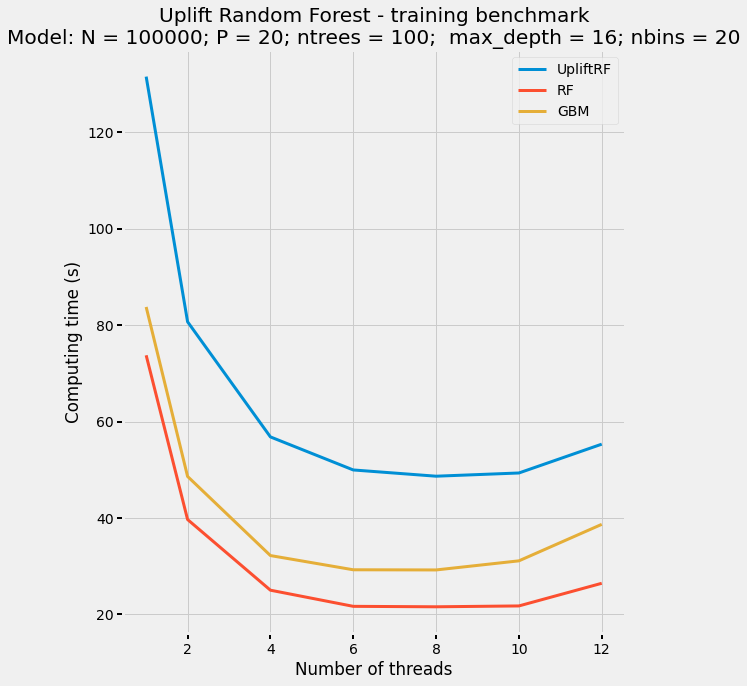

In [23]:
plot_result(uplift_time0, rf_time0, gbm_time0)

In [24]:
N = 100000
P = 20
max_depth = 16
nbins=400
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [25]:
uplift_time1, rf_time1, gbm_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy5e2pc9k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy5e2pc9k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy5e2pc9k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k3xikg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.54401063919067s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.28295397758484s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.19893980026245s
H2O session _sid_806c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps7x_b3v9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps7x_b3v9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps7x_b3v9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4kreed
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 136.0585069656372s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.51726841926575s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 139.14736366271973s
H2O session _sid_901f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxpptk2kr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxpptk2kr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxpptk2kr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cixkk3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 136.56712007522583s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.3325879573822s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.55724954605103s
H2O session _sid_870c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7ybbz40i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7ybbz40i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7ybbz40i\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qhhdfq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 140.5997438430786s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.02116799354553s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.04649138450623s
H2O session _sid_bdf4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_lssggap
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_lssggap\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_lssggap\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7sklrt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.01414966583252s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.75869274139404s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 141.66845035552979s
H2O session _sid_8359 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmw4zx5p9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmw4zx5p9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmw4zx5p9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uc2677
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.82722187042236s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.43054556846619s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.1905653476715s
H2O session _sid_9244 closed.
Uplift 136.10179217656454s
RF 58.22386944293976s
gbm 141.80151001612344s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt2sft7_1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt2sft7_1\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0tcgy3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 126.52970337867737s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.18153429031372s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 126.68812394142151s
H2O session _sid_bbd4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9q5u8fs5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9q5u8fs5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9q5u8fs5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kl75q4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 126.29426193237305s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.38205027580261s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 124.9609923362732s
H2O session _sid_abe8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_kjzr7r3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_kjzr7r3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_kjzr7r3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3kq7h1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 128.67094922065735s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.50352668762207s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 126.63653993606567s
H2O session _sid_9e43 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv7pmdotl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv7pmdotl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv7pmdotl\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vl6hi5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 125.7924690246582s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.63902282714844s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 126.46575665473938s
H2O session _sid_8414 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe3xcomml
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe3xcomml\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe3xcomml\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vujejg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 125.79581308364868s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.15385556221008s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 125.53670597076416s
H2O session _sid_a4b8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxfhnbcot
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxfhnbcot\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxfhnbcot\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bneaco
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 125.85368394851685s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.539345264434814s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 128.1829071044922s
H2O session _sid_b8ba closed.
Uplift 126.48948009808858s
RF 53.89988915125529s
gbm 126.41183765729268s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeci3_m0s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeci3_m0s\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bbma2r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 117.34040808677673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 48.42918515205383s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 111.88326001167297s
H2O session _sid_ba72 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2uyc6zlj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2uyc6zlj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2uyc6zlj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e41e8k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.93697261810303s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.753883838653564s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 115.64120268821716s
H2O session _sid_9b61 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgueh2in0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgueh2in0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgueh2in0\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p38cmb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.20230507850647s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.75935077667236s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.14849185943604s
H2O session _sid_adeb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcc_6okzm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcc_6okzm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcc_6okzm\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jg7las
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.57191205024719s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 48.07279086112976s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 111.98945498466492s
H2O session _sid_b450 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplbaprg4i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplbaprg4i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplbaprg4i\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e55xtv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.74441576004028s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.691062211990356s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 112.76816034317017s
H2O session _sid_85c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5z5o39w9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5z5o39w9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5z5o39w9\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dqbk9x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.53598809242249s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.77931189537048s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 111.2069640159607s
H2O session _sid_9b11 closed.
Uplift 119.22200028101604s
RF 47.91426412264506s
gbm 112.772922317187s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr_dyj7qe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr_dyj7qe\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pgeddm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 114.5710711479187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 43.46338438987732s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 96.05108094215393s
H2O session _sid_9708 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ss0460k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ss0460k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ss0460k\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nnq2qe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.46714901924133s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.14953398704529s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 96.9381058216095s
H2O session _sid_8143 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqe90njwv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqe90njwv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqe90njwv\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xjs13z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.94680571556091s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 46.96660923957825s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 96.92583394050598s
H2O session _sid_a21e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb2d5c8_w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb2d5c8_w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb2d5c8_w\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s6wehl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 114.08502054214478s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 43.36751317977905s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 96.04122018814087s
H2O session _sid_9312 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp81a3ncdt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp81a3ncdt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp81a3ncdt\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o2guwf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.69022297859192s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 43.193278551101685s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 96.92117762565613s
H2O session _sid_a676 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7nbc6q91
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7nbc6q91\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7nbc6q91\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qxuwzz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 114.22751688957214s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 43.37600755691528s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 99.95650839805603s
H2O session _sid_94b3 closed.
Uplift 114.99796438217163s
RF 44.08605448404948s
gbm 97.13898781935374s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmput701mqa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmput701mqa\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4ftaa0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.93590569496155s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 43.286399841308594s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 84.33998394012451s
H2O session _sid_aff3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmzef2ez0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmzef2ez0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmzef2ez0\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ys6s3x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.67363023757935s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.10034489631653s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 84.70120573043823s
H2O session _sid_a930 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6h5k_f13
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6h5k_f13\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6h5k_f13\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_f93y58
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.5281023979187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.17452597618103s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.25467896461487s
H2O session _sid_b3b7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2xbh9ptg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2xbh9ptg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2xbh9ptg\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lg42ri
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.97107696533203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.214558601379395s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.33057379722595s
H2O session _sid_8d1a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiep6f4jd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiep6f4jd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiep6f4jd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6pu6vu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.07781410217285s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.11670994758606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 84.36918878555298s
H2O session _sid_a070 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphukxcggc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphukxcggc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphukxcggc\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_yjzhxl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.67586851119995s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.27914881706238s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 84.45903658866882s
H2O session _sid_9df0 closed.
Uplift 119.8103996515274s
RF 44.02861467997233s
gbm 84.07577796777089s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe_x68d6w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe_x68d6w\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wwlebk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 178.40376543998718s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.24133062362671s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.66453576087952s
H2O session _sid_b5d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnueufs61
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnueufs61\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnueufs61\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6stu2a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 177.76462173461914s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.24875998497009s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 103.19905853271484s
H2O session _sid_9ae0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpri0wkbq5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpri0wkbq5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpri0wkbq5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vgm0nn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 177.88193440437317s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.99145984649658s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 101.09300112724304s
H2O session _sid_91c1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpthk513h4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpthk513h4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpthk513h4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ejzcxr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 178.3045690059662s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.21392440795898s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 103.17800664901733s
H2O session _sid_b9f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuz3bwjq7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuz3bwjq7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuz3bwjq7\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_maex89
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 175.29922485351562s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.10312056541443s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 103.50229740142822s
H2O session _sid_acc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfm5wcfoq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfm5wcfoq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfm5wcfoq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1mkcue
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 178.02358293533325s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.09929442405701s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.53775596618652s
H2O session _sid_98d9 closed.
Uplift 177.61294972896576s
RF 63.64964830875397s
gbm 102.69577590624492s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdq4tdmek
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdq4tdmek\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zjhg7b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 311.2818808555603s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 112.44194507598877s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 160.57626056671143s
H2O session _sid_81bb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4foy8uao
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4foy8uao\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4foy8uao\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_az54uv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 314.08828687667847s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 112.51240754127502s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 157.56497859954834s
H2O session _sid_8efc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp46tevjdw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp46tevjdw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp46tevjdw\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8u5p1c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.17877316474915s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 111.04742407798767s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 157.9055471420288s
H2O session _sid_b171 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp68n6_9c0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp68n6_9c0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp68n6_9c0\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uq8po8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 310.1642835140228s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 112.5462121963501s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 164.013569355011s
H2O session _sid_8675 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqmkuuk_3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqmkuuk_3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqmkuuk_3\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nculkt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.6348707675934s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 110.97592568397522s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.21533799171448s
H2O session _sid_b39a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp38tniohp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp38tniohp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp38tniohp\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dxmhtx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 309.76599955558777s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 110.37675619125366s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 160.00443649291992s
H2O session _sid_9f89 closed.
Uplift 311.3523491223653s
RF 111.65011179447174s
gbm 159.38002169132233s
12 - Uplift = 136.10179217656454, RF = 58.22386944293976, gbm = 141.80151001612344
10 - Uplift = 126.48948009808858, RF = 53.89988915125529, gbm = 126.41183765729268
8 - Uplift = 119.22200028101604, RF = 47.91426412264506, gbm = 112.772922317187
6 - Uplift = 114.99796438217163, RF = 44.08605448404948, gbm = 97.13898781935374
4 - Uplift = 119.8103996515274, RF = 44.02861467997233, gbm = 84.07577796777089
2 - Uplift = 177.6

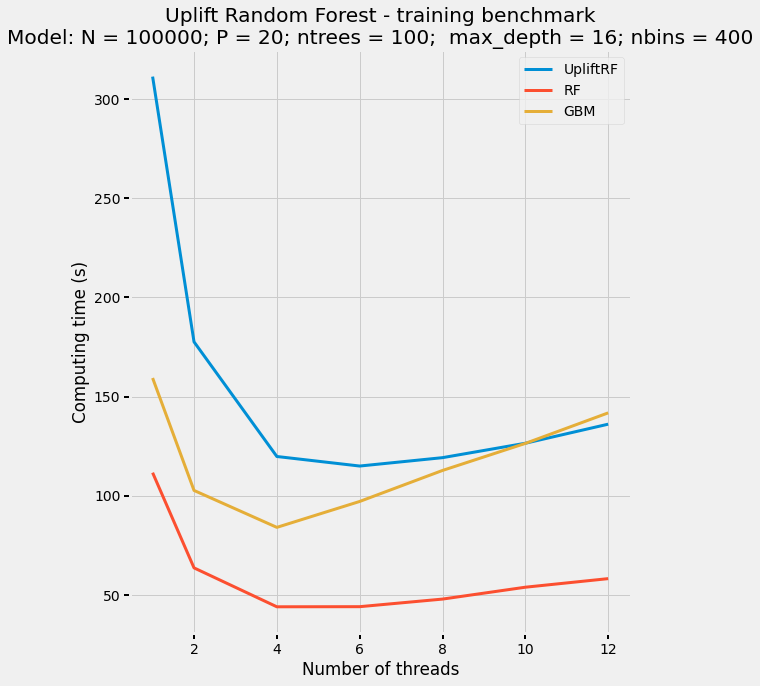

In [26]:
plot_result(uplift_time1, rf_time1, gbm_time1)

In [27]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=2000
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [28]:
uplift_time2, rf_time2, gbm_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp08fehxfm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp08fehxfm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp08fehxfm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u9g5j0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 470.642703294754s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 216.24606823921204s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 800.9241061210632s
H2O session _sid_849c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6q2mspwn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6q2mspwn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6q2mspwn\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_b1m5yh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 471.14657402038574s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 212.98861145973206s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 793.6900765895844s
H2O session _sid_8c9c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmenvnd2f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmenvnd2f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmenvnd2f\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mjy2sc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 476.1446900367737s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 210.70222306251526s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 794.0666837692261s
H2O session _sid_a263 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa173yqog
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa173yqog\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa173yqog\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8uonxf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 474.633508682251s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 212.81049871444702s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 789.266627073288s
H2O session _sid_a9f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc2nc787l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc2nc787l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc2nc787l\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5ysre8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 471.8489103317261s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 208.4991421699524s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 791.7785246372223s
H2O session _sid_b1e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxm5kvvoc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxm5kvvoc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxm5kvvoc\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lzhh0c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 468.10014820098877s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 208.97268724441528s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 787.4210438728333s
H2O session _sid_a2c0 closed.
Uplift 472.08608909447986s
RF 211.703205148379s
gbm 792.8578436772028s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg_3iq7xo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg_3iq7xo\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6om5te
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 428.41904306411743s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 188.47151350975037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 706.8413560390472s
H2O session _sid_bab0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptvoqbdul
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptvoqbdul\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptvoqbdul\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gd3pr9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 432.62981152534485s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 187.4499475955963s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 715.4526977539062s
H2O session _sid_adbe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzei7yu86
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzei7yu86\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzei7yu86\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ztcxia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 424.88590264320374s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 187.48405170440674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 707.8597795963287s
H2O session _sid_9733 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy_u03f8e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy_u03f8e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy_u03f8e\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9mjibx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 432.1239790916443s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 185.88202047348022s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 705.8281512260437s
H2O session _sid_bc17 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpda5134yx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpda5134yx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpda5134yx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ni8hci
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 435.2224454879761s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 188.90867614746094s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 703.4845659732819s
H2O session _sid_b42a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp778ai_e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp778ai_e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp778ai_e\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ris6b2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 424.6354727745056s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 187.16670656204224s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 712.8344085216522s
H2O session _sid_9ab6 closed.
Uplift 429.65277576446533s
RF 187.56048599878946s
gbm 708.7168265183767s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_t4vjo8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_t4vjo8\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_eziuua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 392.1399185657501s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 167.0438585281372s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 636.4525012969971s
H2O session _sid_95d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwfenh31p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwfenh31p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwfenh31p\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ingx8s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 394.04987955093384s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 165.67291712760925s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 643.2532992362976s
H2O session _sid_8201 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj00udbu5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj00udbu5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj00udbu5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_chfgrq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 392.98955726623535s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 166.14575457572937s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 638.1369559764862s
H2O session _sid_a57a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphdhfz0gl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphdhfz0gl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphdhfz0gl\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ewvubg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 393.69559478759766s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 168.5995500087738s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 636.8927004337311s
H2O session _sid_9e7b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptcl_y8sh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptcl_y8sh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptcl_y8sh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_soxxis
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 396.2598342895508s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 165.42441701889038s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 643.8793921470642s
H2O session _sid_9b87 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxlcz6uyh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxlcz6uyh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxlcz6uyh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0gywpl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 392.3876585960388s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 167.19140648841858s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 657.1781742572784s
H2O session _sid_a08a closed.
Uplift 393.58707384268445s
RF 166.6796506245931s
gbm 642.6321705579758s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7ykp4mgl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7ykp4mgl\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9lo61c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 362.0354790687561s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 141.64758563041687s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 543.4294979572296s
H2O session _sid_bd86 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk6uaqjee
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk6uaqjee\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk6uaqjee\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_txxdnu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 357.24383640289307s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 142.133394241333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 553.977313041687s
H2O session _sid_8726 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp85hx31i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp85hx31i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp85hx31i\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2au00c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 357.44345331192017s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 141.95025420188904s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 555.893801689148s
H2O session _sid_b6d1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp88qxn6tb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp88qxn6tb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp88qxn6tb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1unxfz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 357.1829032897949s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.66440725326538s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 559.3048975467682s
H2O session _sid_b76c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppgxob8xz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppgxob8xz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppgxob8xz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3go965
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 354.97105622291565s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 142.45964813232422s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 556.5630187988281s
H2O session _sid_9b16 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_k2_7g6k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_k2_7g6k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_k2_7g6k\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ksrwq6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 359.5513029098511s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.13084721565247s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 548.0757026672363s
H2O session _sid_9d1b closed.
Uplift 358.07133853435516s
RF 143.16435611248016s
gbm 552.8740386168162s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2vm1trh4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2vm1trh4\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p9ib6u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 344.13596272468567s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.1912796497345s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 463.59006333351135s
H2O session _sid_add2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfu5davp4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfu5davp4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfu5davp4\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_irjbte
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 342.21288537979126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 132.54518961906433s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 463.54416275024414s
H2O session _sid_86f7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn5frq9q5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn5frq9q5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn5frq9q5\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_m6qjhk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 339.9370105266571s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.92449951171875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 460.40251755714417s
H2O session _sid_bce6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptguom91q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptguom91q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptguom91q\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g6g70v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 341.46209621429443s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 132.05872654914856s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 463.17070055007935s
H2O session _sid_9c12 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppchvn7xu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppchvn7xu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppchvn7xu\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vab13u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 340.9610469341278s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 132.069406747818s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 460.7911157608032s
H2O session _sid_887c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaxl5xn7u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaxl5xn7u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaxl5xn7u\h2o_potte_started_from_python.err

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_r12f46
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 340.4824330806732s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 132.8943920135498s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 449.67722630500793s
H2O session _sid_9db2 closed.
Uplift 341.53190581003827s
RF 131.78058234850565s
gbm 460.1959643761317s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8svr6mv_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8svr6mv_\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hl1fya
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 440.6833164691925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 158.30060172080994s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 456.6192936897278s
H2O session _sid_8e7e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc9wu1wnb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc9wu1wnb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc9wu1wnb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0xnb1g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 440.7657856941223s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 158.3304569721222s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 454.42338013648987s
H2O session _sid_95c6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjpk_l4uc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjpk_l4uc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjpk_l4uc\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9udem4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 439.1282331943512s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 158.95588397979736s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 455.57833099365234s
H2O session _sid_abb1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpje9z5mre
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpje9z5mre\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpje9z5mre\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wgbu0c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 442.8998682498932s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 156.81265687942505s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 457.7610845565796s
H2O session _sid_a10e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp49oztu8g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp49oztu8g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp49oztu8g\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xapybp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 437.9166257381439s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 159.7483925819397s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 468.47530031204224s
H2O session _sid_9ee0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwso4grhe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwso4grhe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwso4grhe\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_yl67ke
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 433.368177652359s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 161.76611495018005s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 457.2943260669708s
H2O session _sid_9832 closed.
Uplift 439.1270011663437s
RF 158.98568451404572s
gbm 458.3586192925771s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpff10sp_u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpff10sp_u\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_17fk6o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 709.8205091953278s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 255.15467834472656s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 589.2620961666107s
H2O session _sid_b1a2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_73rq8r5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_73rq8r5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_73rq8r5\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7nrzf0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 707.9464900493622s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 255.46456003189087s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 579.6448652744293s
H2O session _sid_8394 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppurqxpqi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppurqxpqi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppurqxpqi\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4lvpkc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 707.8349170684814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 262.7944483757019s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 594.0671074390411s
H2O session _sid_a41e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcagk1_vp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcagk1_vp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcagk1_vp\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_df6m0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 702.6282250881195s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 263.39258885383606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 577.89692902565s
H2O session _sid_9bbc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpakcnjx5e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpakcnjx5e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpakcnjx5e\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nf3l9j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 710.9442987442017s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 262.75678873062134s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 587.6773619651794s
H2O session _sid_9767 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6lmba1dy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6lmba1dy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6lmba1dy\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lowj91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 707.417563199997s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 264.71949100494385s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 583.4028041362762s
H2O session _sid_a986 closed.
Uplift 707.7653338909149s
RF 260.7137592236201s
gbm 585.3251940011978s
12 - Uplift = 472.08608909447986, RF = 211.703205148379, gbm = 792.8578436772028
10 - Uplift = 429.65277576446533, RF = 187.56048599878946, gbm = 708.7168265183767
8 - Uplift = 393.58707384268445, RF = 166.6796506245931, gbm = 642.6321705579758
6 - Uplift = 358.07133853435516, RF = 143.16435611248016, gbm = 552.8740386168162
4 - Uplift = 341.53190581003827, RF = 131.78058234850565, gbm = 460.1959643761317
2 - Uplift = 439.1270

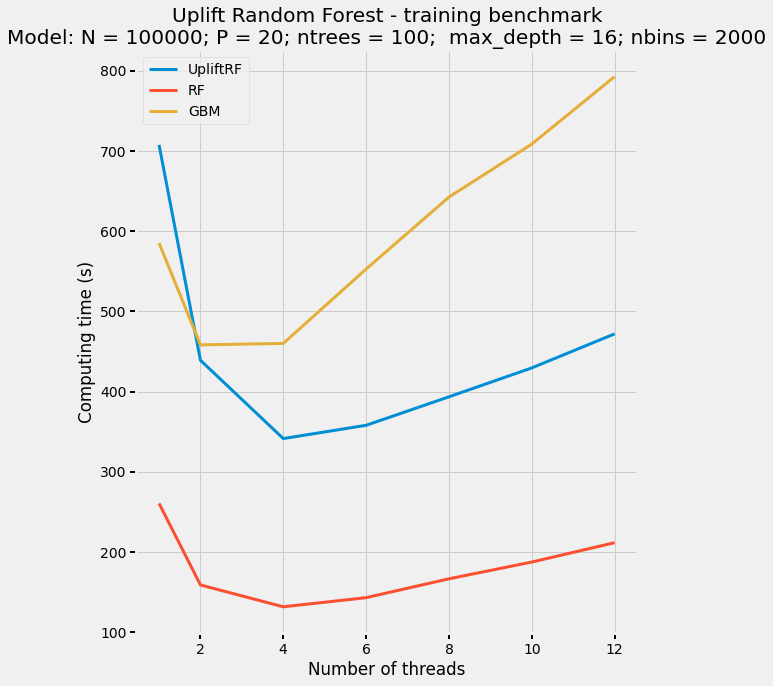

In [29]:
plot_result(uplift_time2, rf_time2, gbm_time2)

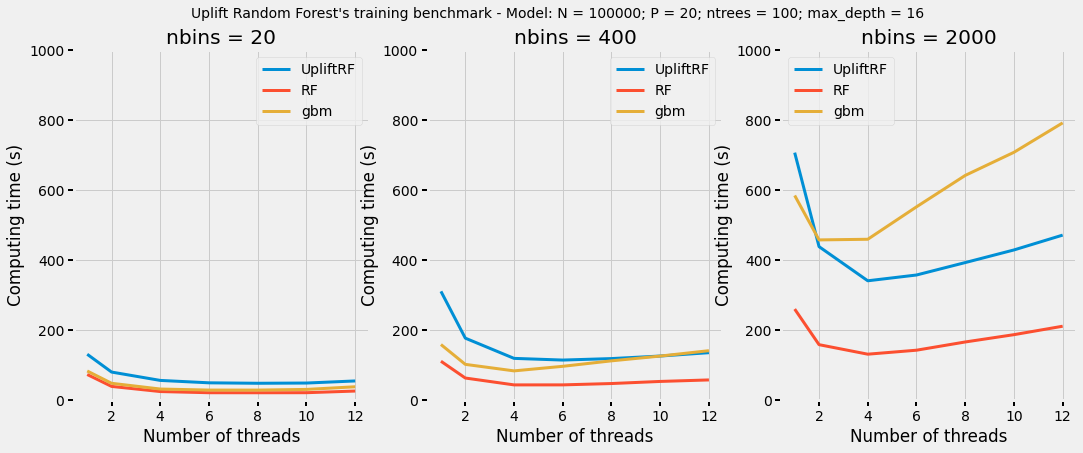

In [30]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"gbm", linewidth=3)    
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [31]:
print(all_predict_uplift)

[{12: 55.30508538087209, 10: 49.32337749004364, 8: 48.6559423605601, 6: 49.95240875085195, 4: 56.81198136011759, 2: 80.70479647318523, 1: 131.59123945236206}, {12: 136.10179217656454, 10: 126.48948009808858, 8: 119.22200028101604, 6: 114.99796438217163, 4: 119.8103996515274, 2: 177.61294972896576, 1: 311.3523491223653}, {12: 472.08608909447986, 10: 429.65277576446533, 8: 393.58707384268445, 6: 358.07133853435516, 4: 341.53190581003827, 2: 439.1270011663437, 1: 707.7653338909149}]


In [32]:
print(all_predict_rf)

[{12: 26.430646697680157, 10: 21.72948455810547, 8: 21.55200680096944, 6: 21.646233240763348, 4: 24.998000383377075, 2: 39.66513856252035, 1: 73.75390768051147}, {12: 58.22386944293976, 10: 53.89988915125529, 8: 47.91426412264506, 6: 44.08605448404948, 4: 44.02861467997233, 2: 63.64964830875397, 1: 111.65011179447174}, {12: 211.703205148379, 10: 187.56048599878946, 8: 166.6796506245931, 6: 143.16435611248016, 4: 131.78058234850565, 2: 158.98568451404572, 1: 260.7137592236201}]


In [33]:
print(all_predict_gbm)

[{12: 38.66202127933502, 10: 31.08882788817088, 8: 29.1992027759552, 6: 29.234978795051575, 4: 32.18564065297445, 2: 48.60602084795634, 1: 83.78122389316559}, {12: 141.80151001612344, 10: 126.41183765729268, 8: 112.772922317187, 6: 97.13898781935374, 4: 84.07577796777089, 2: 102.69577590624492, 1: 159.38002169132233}, {12: 792.8578436772028, 10: 708.7168265183767, 8: 642.6321705579758, 6: 552.8740386168162, 4: 460.1959643761317, 2: 458.3586192925771, 1: 585.3251940011978}]


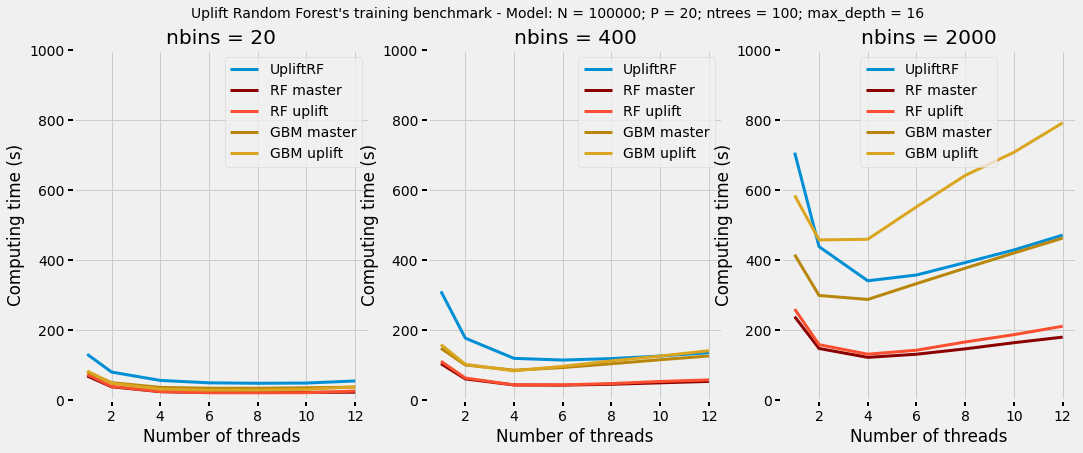

In [34]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf_uplift = [rf_time0, rf_time1, rf_time2]
all_predict_gbm_uplift = [gbm_time0, gbm_time1, gbm_time2]
all_predict_gbm_master = [{12: 37.61737712224325, 10: 35.763516783714294, 8: 34.403014143308006, 6: 34.46197601159414, 4: 36.87945266564687, 2: 50.39029014110565, 1: 81.316055337588}, {12: 126.65784434477489, 10: 115.9064480861028, 8: 104.52700750033061, 6: 93.53562060991923, 4: 86.0655980904897, 2: 100.8912181854248, 1: 148.63932303587595}, {12: 463.4276549418767, 10: 420.92395985126495, 8: 377.53768213589984, 6: 333.4329918225606, 4: 288.21311410268146, 2: 299.583052833875, 1: 416.0625427166621}]
all_predict_rf_master = [{12: 23.168132662773132, 10: 22.61997667948405, 8: 22.246182600657146, 6: 22.211860140164692, 4: 24.65655283133189, 2: 38.57147363821665, 1: 69.44969248771667}, {12: 53.98993988831838, 10: 49.93324279785156, 8: 45.839822133382164, 6: 43.316195487976074, 4: 43.80987751483917, 2: 61.08458606402079, 1: 104.61950925985973}, {12: 180.5314885377884, 10: 164.58640174070993, 8: 146.99212896823883, 6: 131.66858418782553, 4: 122.71838816006978, 2: 148.0921509663264, 1: 238.9851717154185}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color = "darkgoldenrod")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")      
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

## Evaluation Stage

In [35]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth+1)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        
    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])

    return eif_means, if_means 

def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [36]:
# Evaluation stage parameters

N = 500
P = 2
N_train = 500
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time18, if_time18 = run_predict_benchmark(X_train, X_test)

NameError: name 'make_blobs' is not defined

In [ ]:
plot_predict(eif_time18, if_time18)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 30
N_train = 500_000
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time10, if_time10 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time10, if_time10)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 5_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time11, if_time11 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time11, if_time11)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 20_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time12, if_time12 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time12, if_time12)

### Real Credit Card Fraud Detection Data

In [ ]:
sample_sizes = []

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = 256
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time14, if_time14 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time14, if_time14)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time15, if_time15 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time15, if_time15)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time16, if_time16 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time16, if_time16)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.10)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time17, if_time17 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time17, if_time17)

In [ ]:
all_predict_eif = [eif_time14, eif_time15, eif_time16]
all_predict_if = [if_time14, if_time15, if_time16]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Extended Isolation Forest's scoring benchmark - Frame to score: N = {N}; P = {P}. Model: N = {N_train}; P = {P}; ntrees = {ntrees}.", fontsize=14)

for eif_time, if_time, i in zip(all_predict_eif, all_predict_if, range(1, len(sample_sizes) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"EIF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in if_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"IF", linewidth=3)    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 40)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"sample_size = {sample_sizes[i - 1]}; max_depth = {math.ceil(math.log(sample_sizes[i - 1], 2))}")

plt.savefig(f"h2o-score-perf_credit{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()